<a href="https://colab.research.google.com/github/Brimarolafs/Gervigreind-Lokaverkefni-BJV/blob/main/Gervi_loka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from PIL import Image
import numpy as np

def load_image(infilename, grayscale = False):
    if grayscale:
        img = Image.open( infilename ).convert('L')
    else:
        img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( np.asarray( np.clip(npdata,0,255), dtype="uint8"), "L" )
    img.save( outfilename )



In [10]:
#make autoencoder
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import np_utils
from keras import optimizers
from tensorflow.keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D

#input is 819 transparent Pokemon images in png format size 256x256.
#output is 819 transparent Pokemon images in png format size 256x256.

#add encoded and decoded

#If input shape is (256,256,4) the first con

input_shape = keras.Input(shape=(256, 256, 4))

x = layers.Conv2D(64, 3, activation="relu", padding="same")(input_shape)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(2, padding="same")(x)
x = layers.Conv2D(8, 3, activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D(2, padding="same")(x)

# at this point the representation is (16, 16, 8) i.e. 2048-dimensional

x = layers.Conv2D(8, 3, activation="relu", padding="same")(encoded)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.UpSampling2D(2)(x)
decoded = layers.Conv2D(4, 3, activation="sigmoid", padding="same")(x)

autoencoder = keras.Model(input_shape, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 4)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      2368      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 16)        4624  

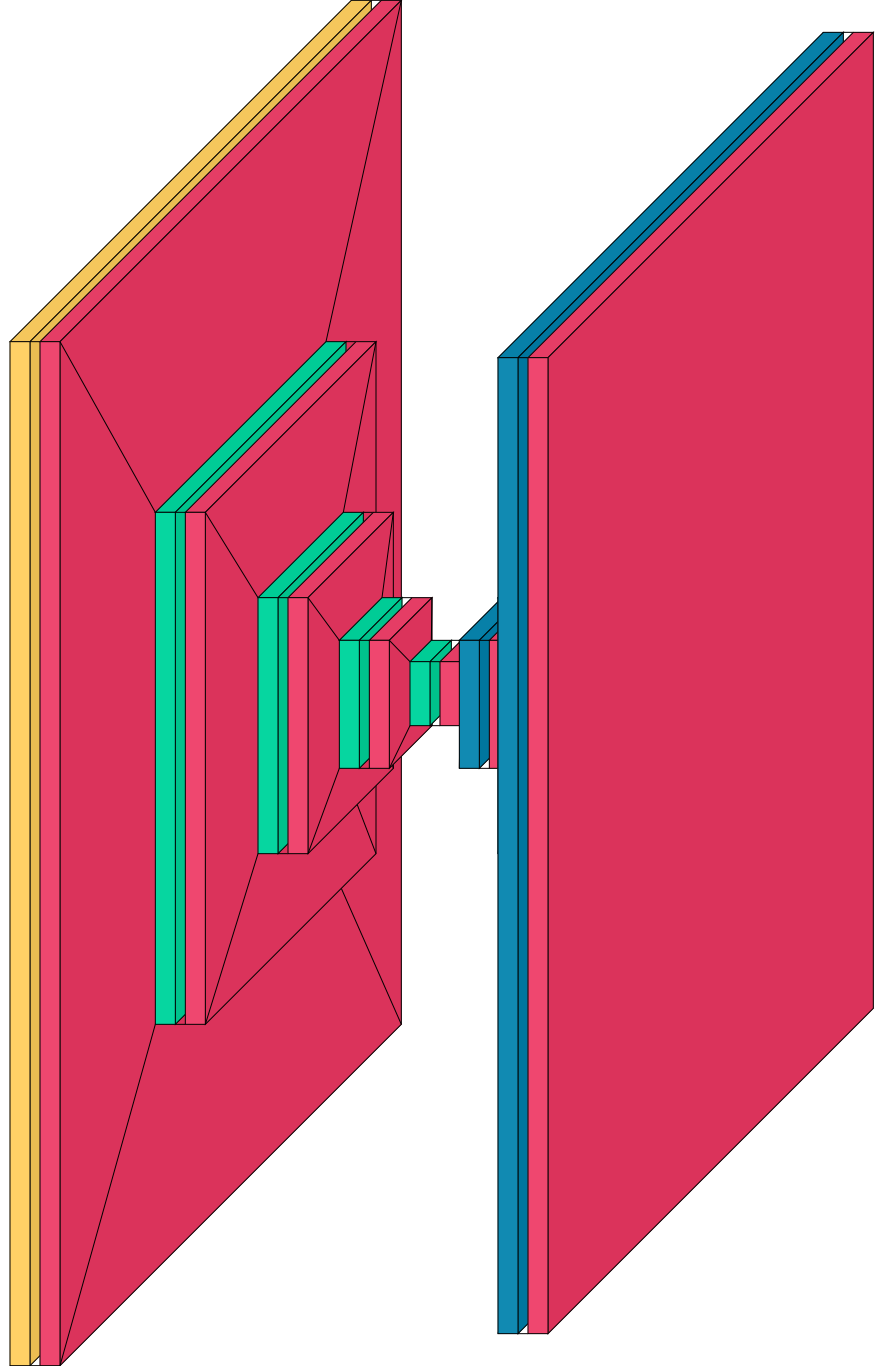

In [11]:
import visualkeras

visualkeras.layered_view(autoencoder).show() # display using your system viewer
visualkeras.layered_view(autoencoder, to_file='autoencoder.png') # write to disk

In [6]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 4.1 MB/s 
